In [8]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models

import keras
import tensorflow as tf
from tensorflow import data as tf_data
from tensorboard.plugins.hparams import api as hp

from sklearn.model_selection import train_test_split

from preprocess_common import *

/Users/shahzadjalil/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Define the HyperParameters

We fix some hyperparmeters like IMG_SIZE at a per model level, since each model excels at certain image sizes [1](https://link.springer.com/chapter/10.1007/978-3-030-86340-1_11). 

We also fix batch size and other parameters due to memory and compute constraints as well. We fix the seed for reproducibility

In [9]:
PATH="archive/"

AUTO = tf_data.AUTOTUNE # Parallelize data loading
#Hyperparameters
BUFFER_SIZE = 1024
BATCH_SIZE = 32
VALIDATION_SIZE = 0.2
RESIZE_SIZE = (512,512)

SEED = 44

## Load the CSV's 

In [10]:
class_names=['Human', 'AI']

In [11]:
train_df = pd.read_csv('./archive/train.csv', index_col=0)
test_df = pd.read_csv('./archive/test.csv')

train_paths = train_df["file_name"].array
train_labels = train_df["label"].array

## Splitting Training and Validation Data

In [12]:
train_labels = train_labels.numpy() if isinstance(train_labels, tf.Tensor) else train_labels

# Split the training data into training and validation sets balanced by label
(train_paths, val_paths, 
 train_labels, val_labels) = train_test_split(train_paths, 
                 train_labels, 
                 test_size=0.2, 
                 stratify=train_labels,
                 random_state=SEED)
 
train_labels = keras.ops.one_hot(train_labels,2)
val_labels = keras.ops.one_hot(val_labels,2)

def create_datasets(train_paths, train_labels, val_paths, val_labels, image_size):
    """ Creates the training and validation datasets for a certain image size.
    
        Args:
            train_paths (list): list of paths to training images
            train_labels (list): list of labels for training images
            val_paths (list): list of paths to validation images
            val_labels (list): list of labels for validation images
            image_size (tuple): size to crop the images to
        Returns:
            (tuple): image tensor and label
    """
    preprocess = Preprocess(RESIZE_SIZE, image_size)
    # Shuffles and batches the datasets
    train_ds_one = (
        tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
        .shuffle(BUFFER_SIZE, seed=SEED * 3)
        .map(lambda filename, label: (preprocess.resize_augment_image(PATH+filename, augment=True, c_jitter=True),label), num_parallel_calls=AUTO, deterministic=True)
    )
    train_ds_two = (
        tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
        .shuffle(BUFFER_SIZE, seed=SEED * 2) 
        .map(lambda filename, label: (preprocess.resize_augment_image(PATH+filename, augment=True, c_jitter=True),label), num_parallel_calls=AUTO, deterministic=True)
    )
    # Combine the two datasets for CutMix
    train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))
    val_ds = (
        tf_data.Dataset.from_tensor_slices((val_paths, val_labels))
        .map(lambda filename, label: (preprocess.resize_augment_image(PATH+filename),label), num_parallel_calls=AUTO, deterministic=True)
        .batch(BATCH_SIZE, num_parallel_calls=AUTO, deterministic=True)
        .prefetch(AUTO)
    )
    return train_ds, val_ds


## Applying CutMix

In [13]:
def create_model_dataset(img_size, ram_budget):
    """ Creates the training and validation datasets.
    
    Args:
        img_size (tuple): size to crop the images to
        ram_budget (int): RAM budget for autotuning
    Returns:
        (): dataset
    """
    mixer = Mix(img_size=img_size[0])
    train_ds, val_ds = create_datasets(train_paths, train_labels, val_paths, val_labels, img_size)

    train_ds_cm = (
        train_ds.shuffle(BUFFER_SIZE)
        .map(mixer.cutmix, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE, num_parallel_calls=AUTO)
        .prefetch(AUTO)
    )


    options = tf_data.Options()
    options.autotune.enabled = True
    options.autotune.ram_budget = ram_budget
    train_ds_cm = train_ds_cm.with_options(options)
    
    return train_ds_cm, val_ds


## Image Saving Helper functions for Consistent Training between Group Members

In [14]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value, quality=100).numpy()])
    )
    
def label_feature(value):
    """Returns a int64_list from a one hot encoded label."""
    value = int(tf.argmax(value).numpy())
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def create_example(image, label):
    """Create a tf.train.Example from an image and label."""
    feature = {
        "image": image_feature(image),
        "label": label_feature(label)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def parse_tfrecord_fn(example, model):
    """Parse the serialized example and preprocess the image."""
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    
    # Decode the image
    image = tf.io.decode_jpeg(example["image"], channels=3)
    
    # Resize the image to the required input size
    image = tf.image.resize(image, [224, 224])  # ResNet-50 input size
    
    # Convert image to float32 and normalize to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Normalize to [-1, 1] for ResNet-50
    image = (image - 0.5) * 2.0  # Scale to [-1, 1]
    
    # One-hot encode the label
    label = tf.one_hot(example["label"], depth=2)
    
    return image, label

def save_to_tfrecord(dataset, filename):
    """Save the dataset to a TFRecord file.
    
    Args:
        dataset (): dataset
        filename (str): name of the TFRecord file
    """
    with tf.io.TFRecordWriter(filename) as writer:
        for image_batch, label_batch in dataset:
            for i in range(image_batch.shape[0]):  # Iterate over batch elements
                example = create_example(image_batch[i], label_batch[i])
                writer.write(example.SerializeToString())
                
def load_tfrecord(filename, model="efficientnet"):
    """Load a TFRecord file.
    
    Args:
        filename (str): name of the TFRecord file
        model (str): name of the model
        Returns:
        (): dataset
    """
    dataset = tf_data.TFRecordDataset(filename)
    dataset = dataset.map(lambda example: parse_tfrecord_fn(example, model), num_parallel_calls=AUTO, deterministic=True).batch(BATCH_SIZE).prefetch(AUTO)
    return dataset

def load_tfrecord1(filename, model="resnet"):
    """Loads a TFRecord file."""
    dataset = tf_data.TFRecordDataset(filename)
    dataset = dataset.map(lambda example: parse_tfrecord_fn(example, model), 
                       num_parallel_calls=AUTO, deterministic=True)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTO)
    return dataset

## Saving to TFRecord

In [15]:
models = {
    "resnet": (224,224),
    "efficientnet": (380,380),
    "swin_transformer": (256,256)
}
if not os.path.exists("./records"):
    os.makedirs("./records")
for model in models:
    model_train_ds, val_ds = create_model_dataset(models[model], models[model][0]*models[model][1]*models[model][1]*BATCH_SIZE)
    save_to_tfrecord(model_train_ds, f"records/{model}_train.tfrecord")
    save_to_tfrecord(val_ds, f"records/{model}_val.tfrecord")

2025-03-19 15:35:01.188563: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 15:39:23.190069: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Training EfficientNet
We are now specifically implementing for EfficientNet

## Loading from TFRecords

Here we utilize a Grid Search to optimize for the width of the hidden unit in the new classfication head as well as the dropout rate.

Because of computational constraints we fix Epochs and instead use Early Stopping, and we fix Learning Rate, as well as the previously fixed Batch Size as well.

# ResNet 

In [15]:
IMG_SIZE_ResNet = (224,224)

In [25]:
res_train_ds = load_tfrecord1("records/resnet_train.tfrecord", "resnet")
res_val_ds = load_tfrecord1("records/resnet_val.tfrecord", "resnet")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..509.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..509.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..509.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..509.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..509.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..509.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..509.0].
Clipping input data to the valid range for imshow with 

(224, 224, 3)


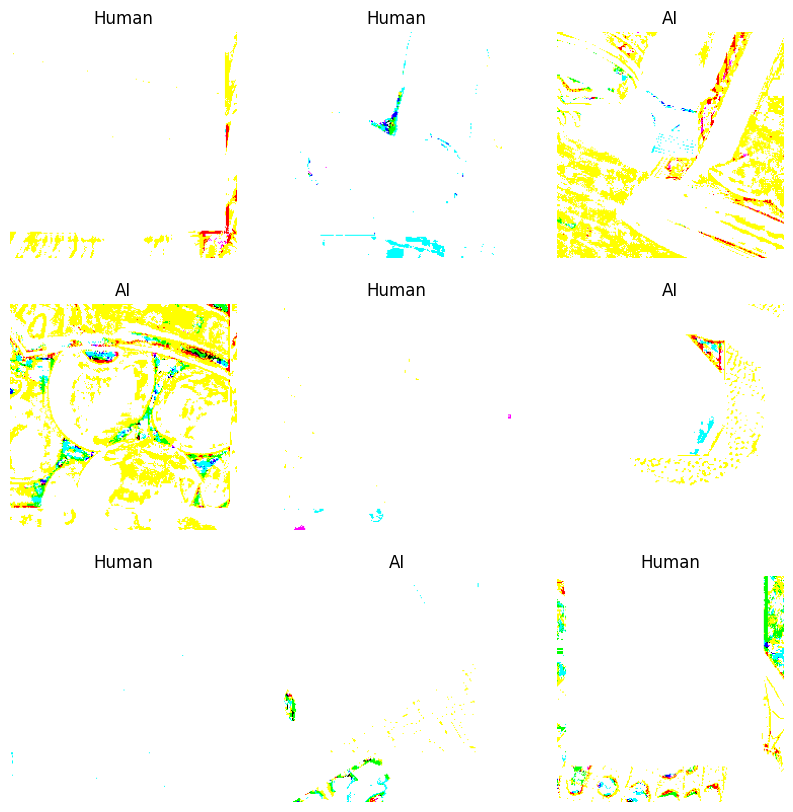

In [27]:
image_batch, label_batch = next(iter(res_train_ds))
print(image_batch[0].shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [19]:

from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


NUM_CLASSES = 2  
LEARNING_RATE = 0.0001
MOMENTUM = 0.9
BATCH_SIZE = 32
EPOCHS = 32

# Custom Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(focal_loss, axis=-1)
    return focal_loss_fn

# Stochastic Weight Averaging (SWA) 
class SWA(tf.keras.callbacks.Callback):
    def __init__(self, swa_epoch):
        super(SWA, self).__init__()
        self.swa_epoch = swa_epoch 

    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
        elif epoch > self.swa_epoch:
            for i, layer in enumerate(self.model.layers):
                self.swa_weights[i] = (self.swa_weights[i] * (epoch - self.swa_epoch) + self.model.get_weights()[i]) / (epoch - self.swa_epoch + 1)

    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)

# ResNet-50 Model
def build_resnet50(num_frozen_layers):
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layer in base_model.layers[:num_frozen_layers]:
        layer.trainable = False
    
    # Add custom layers
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x) 
    
    model = models.Model(inputs, outputs)
    return model

# Compile the Model
def compile_model(model, learning_rate, momentum):
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, clipvalue=1.0)  # Gradient Clipping
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(),  # Use Focal Loss
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

# Train the Model
def train_model(model, train_ds, val_ds, epochs, batch_size):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('resnet50_best_model.keras', save_best_only=True),
        SWA(swa_epoch=20)  # Start SWA after 20 epochs
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )
    return history

# Fine-Tune the 
def fine_tune_model(model, train_ds, val_ds, epochs, batch_size, fine_tune_lr):
    # Unfreeze a few layers
    for layer in model.layers[-20:]: 
        layer.trainable = True
    
    # lower learning rate
    model.compile(
        optimizer=SGD(learning_rate=fine_tune_lr, momentum=MOMENTUM, clipvalue=1.0),
        loss=focal_loss(),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
   
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )
    return history

# preprocessed datasets
res_train_ds = load_tfrecord1("records/resnet_train.tfrecord", "resnet")
res_val_ds = load_tfrecord1("records/resnet_val.tfrecord", "resnet")

# Build the model (Freeze the first 100 layers)
model = build_resnet50(num_frozen_layers=100) 

# Compile the model
compile_model(model, learning_rate=LEARNING_RATE, momentum=MOMENTUM)

# Train the model
history = train_model(model, res_train_ds, res_val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Fine-tune
fine_tune_history = fine_tune_model(model, res_train_ds, res_val_ds, epochs=10, batch_size=BATCH_SIZE, fine_tune_lr=1e-5)


val_loss, val_accuracy, val_auc = model.evaluate(res_val_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")

Epoch 1/32
    683/Unknown 1475s 2s/step - accuracy: 0.5521 - auc: 0.5730 - loss: 0.0728

KeyboardInterrupt: 

TypeError: The dataset length is unknown.

# SwinTransformer